# Day 4: ARIMA and Forecasting
## Week 3: Time Series Analysis for Finance

---

**Learning Objectives:**
- Understand ARIMA(p,d,q) models
- Build forecasting pipelines
- Evaluate forecast accuracy
- Handle non-stationary data

In [2]:
# Day 4 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("ARIMA AND FORECASTING - DAY 4")
print("=" * 60)

ARIMA AND FORECASTING - DAY 4


## 1. ARIMA(p,d,q) Models

ARIMA = AutoRegressive Integrated Moving Average

- **p**: AR order (autoregressive terms)
- **d**: Differencing order (integration)
- **q**: MA order (moving average terms)

The 'd' term handles non-stationarity:
- d=0: ARMA (already stationary)
- d=1: First difference (most common)
- d=2: Second difference (rarely needed)

ARIMA: DIFFERENCING PARAMETER (d)

ADF Test Results at Different Differencing Levels:
--------------------------------------------------
d=0 (Original)           : ADF stat = 0.2555, p = 0.9752 ✗
d=1 (First Diff)         : ADF stat = -14.0228, p = 0.0000 ✓
d=2 (Second Diff)        : ADF stat = -13.7703, p = 0.0000 ✓

→ d=1 is sufficient for price data


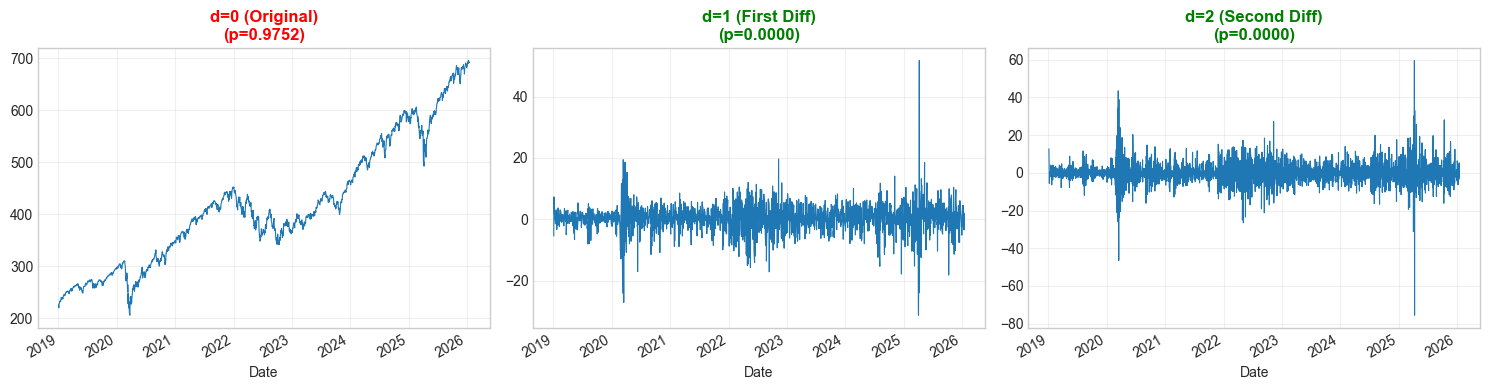

In [3]:
# Understanding the 'd' parameter
print("=" * 60)
print("ARIMA: DIFFERENCING PARAMETER (d)")
print("=" * 60)

spy_price = prices['SPY']

# Test stationarity at different differencing levels
print("\nADF Test Results at Different Differencing Levels:")
print("-" * 50)

series_dict = {
    'd=0 (Original)': spy_price,
    'd=1 (First Diff)': spy_price.diff().dropna(),
    'd=2 (Second Diff)': spy_price.diff().diff().dropna()
}

for name, series in series_dict.items():
    adf_stat, adf_p = adfuller(series.dropna())[:2]
    stationary = '✓' if adf_p < 0.05 else '✗'
    print(f"{name:<25}: ADF stat = {adf_stat:.4f}, p = {adf_p:.4f} {stationary}")

print("\n→ d=1 is sufficient for price data")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, series) in zip(axes, series_dict.items()):
    series.plot(ax=ax, lw=0.8)
    adf_p = adfuller(series.dropna())[1]
    color = 'green' if adf_p < 0.05 else 'red'
    ax.set_title(f'{name}\n(p={adf_p:.4f})', fontweight='bold', color=color)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Fit ARIMA on price data
print("=" * 60)
print("ARIMA MODEL ON PRICE DATA")
print("=" * 60)

# ARIMA(1,1,1) on prices
model = ARIMA(spy_price, order=(1, 1, 1))
fit = model.fit()

print(fit.summary())

ARIMA MODEL ON PRICE DATA
                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                 1771
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5239.315
Date:                Tue, 20 Jan 2026   AIC                          10484.630
Time:                        23:40:57   BIC                          10501.066
Sample:                             0   HQIC                         10490.702
                               - 1771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4786      0.127     -3.772      0.000      -0.727      -0.230
ma.L1          0.3927      0.132      2.976      0.003       0.134       0.651
sigma2        21.8075     

## 2. Train-Test Split for Time Series

TIME SERIES TRAIN-TEST SPLIT
Training period: 2019-01-02 to 2024-08-16
Testing period:  2024-08-19 to 2026-01-16
Training samples: 1416
Testing samples:  355


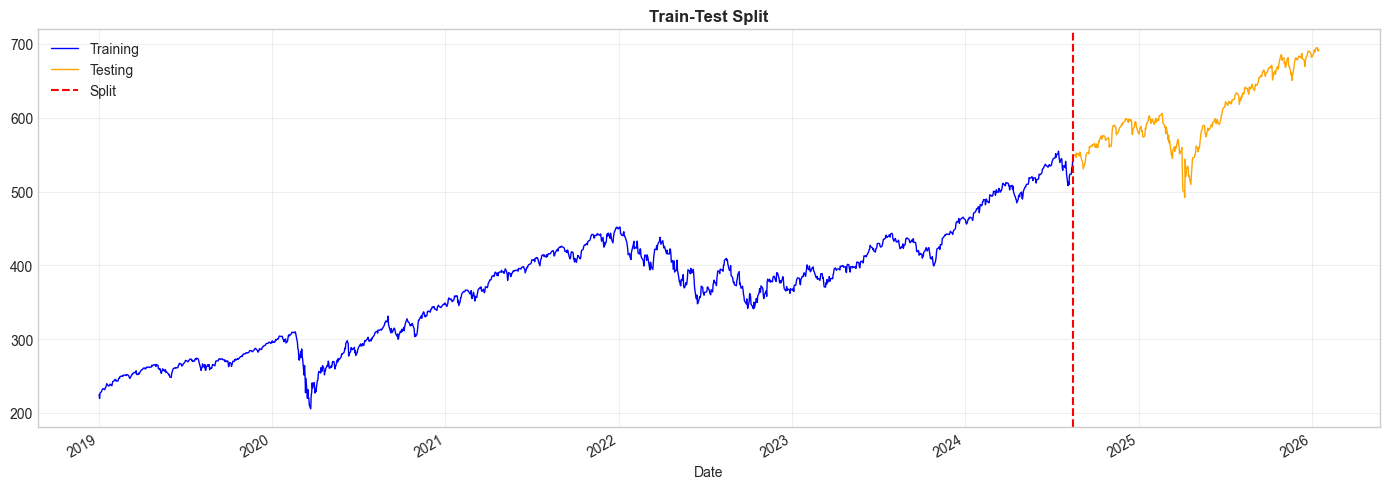

In [5]:
# Time series train-test split
print("=" * 60)
print("TIME SERIES TRAIN-TEST SPLIT")
print("=" * 60)

# Use last 20% for testing
split_idx = int(len(spy_price) * 0.8)
train = spy_price[:split_idx]
test = spy_price[split_idx:]

print(f"Training period: {train.index[0].date()} to {train.index[-1].date()}")
print(f"Testing period:  {test.index[0].date()} to {test.index[-1].date()}")
print(f"Training samples: {len(train)}")
print(f"Testing samples:  {len(test)}")

# Visualize split
fig, ax = plt.subplots(figsize=(14, 5))

train.plot(ax=ax, label='Training', color='blue', lw=1)
test.plot(ax=ax, label='Testing', color='orange', lw=1)
ax.axvline(train.index[-1], color='red', linestyle='--', label='Split')
ax.set_title('Train-Test Split', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Forecasting with ARIMA

ARIMA FORECASTING


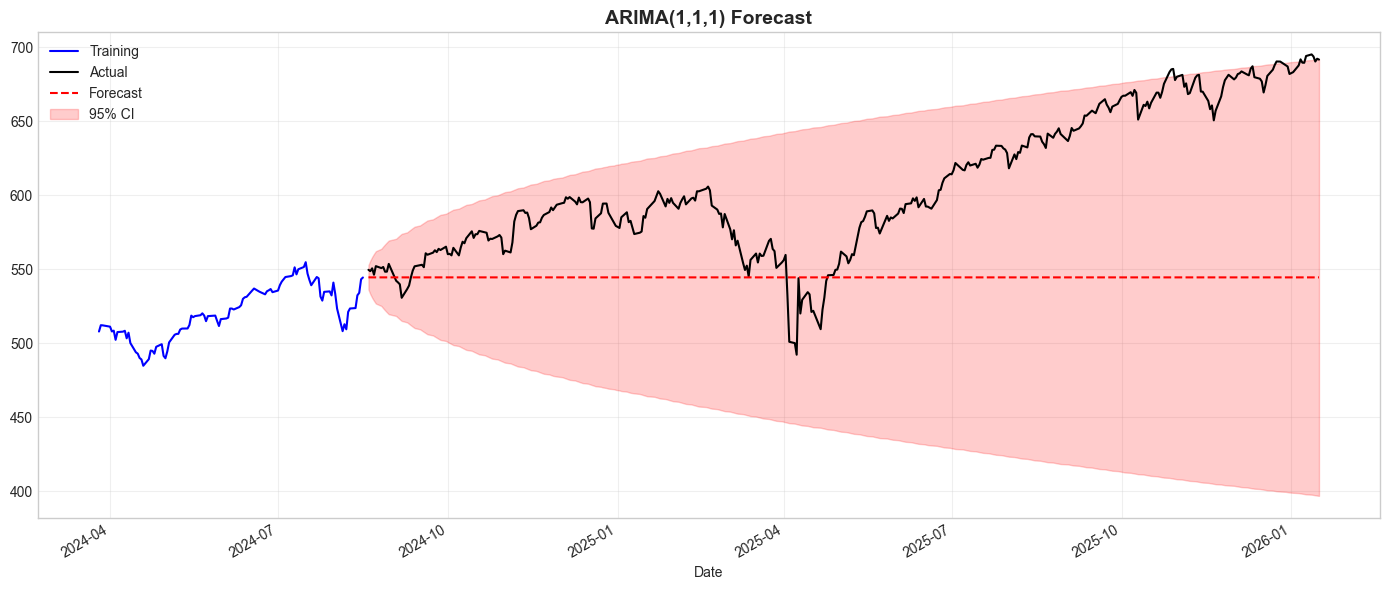


⚠️ Notice how forecast quickly converges to a straight line!
   This is typical for ARIMA on financial data.


In [6]:
# ARIMA Forecasting
print("=" * 60)
print("ARIMA FORECASTING")
print("=" * 60)

# Fit on training data
model = ARIMA(train, order=(1, 1, 1))
fit = model.fit()

# Forecast
forecast_steps = len(test)
forecast = fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)

# Set index to match test
forecast_mean.index = test.index
forecast_ci.index = test.index

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

# Plot last portion of training
train[-100:].plot(ax=ax, label='Training', color='blue', lw=1.5)
test.plot(ax=ax, label='Actual', color='black', lw=1.5)
forecast_mean.plot(ax=ax, label='Forecast', color='red', linestyle='--', lw=1.5)

ax.fill_between(forecast_ci.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1],
                alpha=0.2, color='red', label='95% CI')

ax.set_title('ARIMA(1,1,1) Forecast', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ Notice how forecast quickly converges to a straight line!")
print("   This is typical for ARIMA on financial data.")

## 4. Forecast Evaluation Metrics

In [7]:
# Forecast evaluation metrics
print("=" * 60)
print("FORECAST EVALUATION METRICS")
print("=" * 60)

def evaluate_forecast(actual, predicted, name='Model'):
    """Calculate forecast evaluation metrics."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Directional accuracy (for returns)
    actual_dir = np.sign(actual.diff().dropna())
    pred_dir = np.sign(predicted.diff().dropna())
    dir_acc = (actual_dir == pred_dir).mean() * 100
    
    print(f"\n{name}:")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Directional Accuracy: {dir_acc:.1f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'Dir_Acc': dir_acc}

# Evaluate ARIMA forecast
arima_metrics = evaluate_forecast(test, forecast_mean, 'ARIMA(1,1,1)')

# Compare with naive forecast (random walk)
naive_forecast = train.iloc[-1]  # Last value repeated
naive_series = pd.Series([naive_forecast] * len(test), index=test.index)

naive_metrics = evaluate_forecast(test, naive_series, 'Naive (Random Walk)')

FORECAST EVALUATION METRICS

ARIMA(1,1,1):
  MAE:  $63.98
  RMSE: $78.20
  MAPE: 10.06%
  Directional Accuracy: 5.1%

Naive (Random Walk):
  MAE:  $64.06
  RMSE: $78.27
  MAPE: 10.07%
  Directional Accuracy: 0.0%


ROLLING ONE-STEP-AHEAD FORECAST
Performing rolling forecast (this may take a moment)...
  Completed 50/355 forecasts
  Completed 100/355 forecasts
  Completed 150/355 forecasts
  Completed 200/355 forecasts
  Completed 250/355 forecasts
  Completed 300/355 forecasts
  Completed 350/355 forecasts

Rolling ARIMA(1,1,1):
  MAE:  $4.03
  RMSE: $6.16
  MAPE: 0.68%
  Directional Accuracy: 49.7%


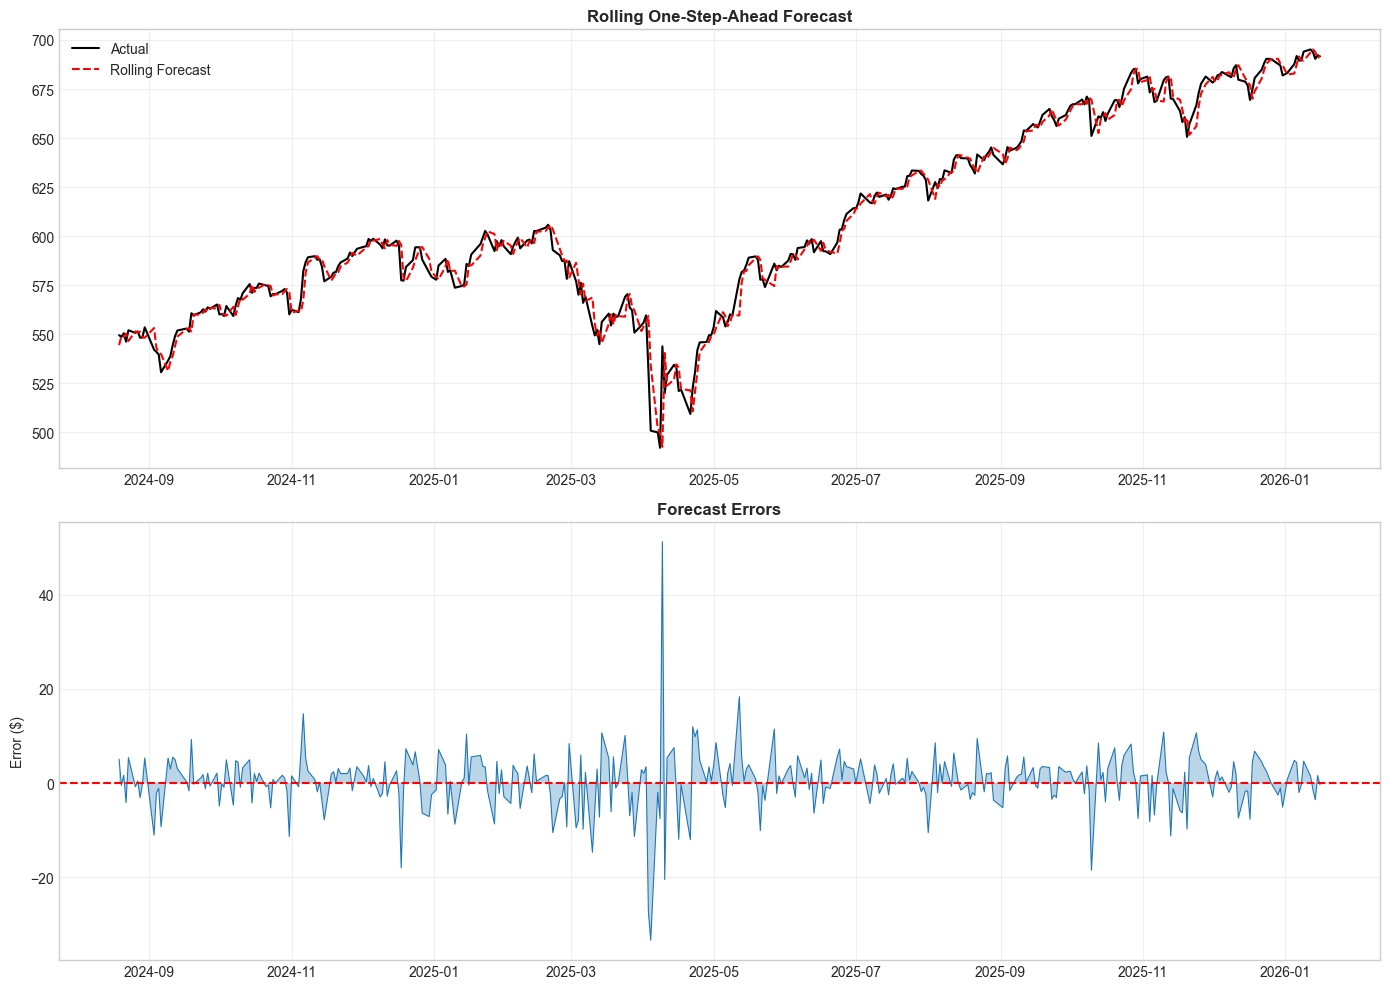

In [8]:
# Rolling forecast (one-step-ahead)
print("=" * 60)
print("ROLLING ONE-STEP-AHEAD FORECAST")
print("=" * 60)

# More realistic: one-step-ahead forecasts
rolling_forecasts = []
history = list(train)

print("Performing rolling forecast (this may take a moment)...")

for i, actual in enumerate(test):
    # Fit model on history
    model = ARIMA(history, order=(1, 1, 1))
    fit = model.fit()
    
    # One-step forecast
    fc = fit.forecast(steps=1)[0]
    rolling_forecasts.append(fc)
    
    # Add actual to history
    history.append(actual)
    
    if (i + 1) % 50 == 0:
        print(f"  Completed {i+1}/{len(test)} forecasts")

rolling_forecasts = pd.Series(rolling_forecasts, index=test.index)

# Evaluate rolling forecast
rolling_metrics = evaluate_forecast(test, rolling_forecasts, 'Rolling ARIMA(1,1,1)')

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full forecast
axes[0].plot(test.index, test.values, label='Actual', color='black', lw=1.5)
axes[0].plot(test.index, rolling_forecasts.values, label='Rolling Forecast', 
             color='red', linestyle='--', lw=1.5)
axes[0].set_title('Rolling One-Step-Ahead Forecast', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = test - rolling_forecasts
axes[1].plot(errors, lw=0.8)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].fill_between(errors.index, errors, 0, alpha=0.3)
axes[1].set_title('Forecast Errors', fontweight='bold')
axes[1].set_ylabel('Error ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FORECASTING RETURNS vs PRICES

Return Forecast Results:
  Directional Accuracy: 53.7%
  (Random would give ~50%)


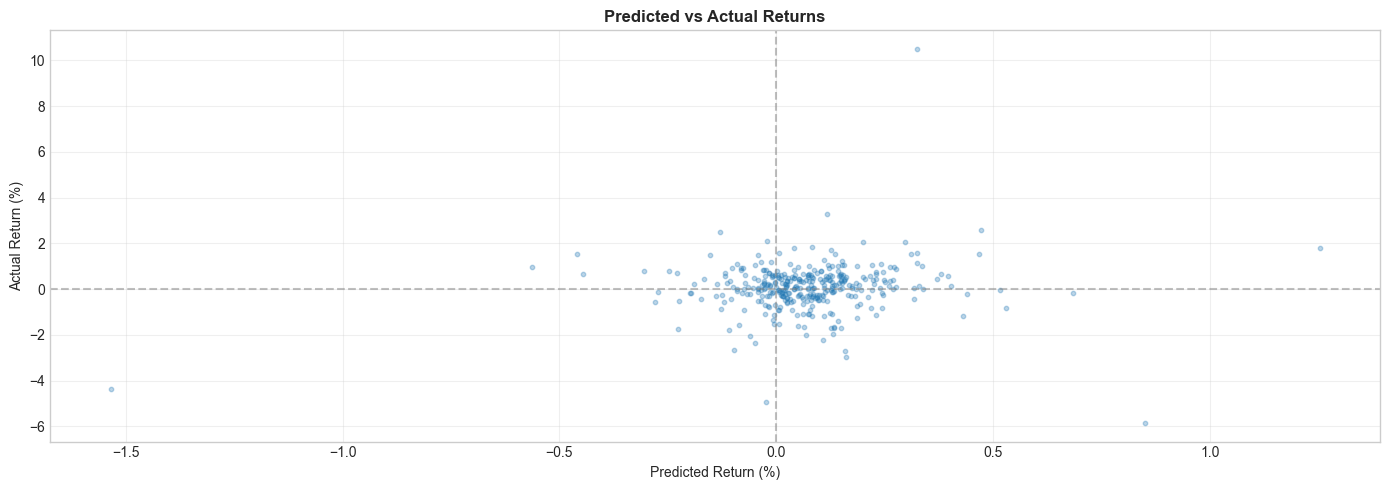

In [9]:
# Compare forecasting on returns vs prices
print("=" * 60)
print("FORECASTING RETURNS vs PRICES")
print("=" * 60)

spy_returns = returns['SPY'] * 100
split_idx = int(len(spy_returns) * 0.8)
train_ret = spy_returns[:split_idx]
test_ret = spy_returns[split_idx:]

# Fit ARMA on returns (d=0 since returns are stationary)
model_ret = ARIMA(train_ret, order=(1, 0, 1))
fit_ret = model_ret.fit()

# Rolling forecast on returns
ret_forecasts = []
history_ret = list(train_ret)

for i, actual in enumerate(test_ret):
    model = ARIMA(history_ret, order=(1, 0, 1))
    fit = model.fit()
    fc = fit.forecast(steps=1)[0]
    ret_forecasts.append(fc)
    history_ret.append(actual)

ret_forecasts = pd.Series(ret_forecasts, index=test_ret.index)

# Directional accuracy
actual_dir = np.sign(test_ret)
pred_dir = np.sign(ret_forecasts)
dir_acc = (actual_dir == pred_dir).mean() * 100

print(f"\nReturn Forecast Results:")
print(f"  Directional Accuracy: {dir_acc:.1f}%")
print(f"  (Random would give ~50%)")

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))

ax.scatter(ret_forecasts, test_ret, alpha=0.3, s=10)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Predicted Return (%)')
ax.set_ylabel('Actual Return (%)')
ax.set_title('Predicted vs Actual Returns', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 4

### ARIMA Components:
- **p**: AR order (lags of the series)
- **d**: Differencing (1 for prices, 0 for returns)
- **q**: MA order (lags of errors)

### Forecasting Best Practices:
1. Use train-test split (time-based, no shuffle!)
2. Rolling forecasts more realistic than multi-step
3. Compare against naive benchmark
4. Focus on directional accuracy for trading

### Key Metrics:
| Metric | Use Case |
|--------|----------|
| MAE | Average error magnitude |
| RMSE | Penalizes large errors |
| MAPE | Percentage error |
| Directional Accuracy | Trading signals |

### Reality Check:
- ARIMA forecasts quickly revert to mean
- Financial returns are nearly unpredictable
- Don't expect >55% directional accuracy!

### Interview Questions:
- "What does the 'd' in ARIMA stand for?"
- "How do you evaluate forecast accuracy?"
- "Why use rolling forecasts instead of multi-step?"